In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsFinalDataset
from pathlib import Path

import matplotlib.pyplot as plt

from dtw import dtw

In [2]:
noise_type='other'

In [3]:
# Dataset
datapath = Path('data')

dataset_noRE = TsFinalDataset(datapath/'CaseI-Attacks without any change.csv', noise_type="none")
dataset_RE = TsFinalDataset(datapath/'CaseII.csv', noise_type='none')

data_normal_noRE = dataset_noRE.data_normal
data_attacked_noRE = dataset_noRE.data_attacked

data_normal_RE = dataset_RE.data_normal
data_attacked_RE = dataset_RE.data_attacked

data_normal_noRE.size(), data_attacked_noRE.size(), data_normal_RE.size(), data_attacked_RE.size()

(torch.Size([15, 2045, 33]),
 torch.Size([15, 2045, 33]),
 torch.Size([15, 1973, 33]),
 torch.Size([15, 1973, 33]))

In [4]:
normal_seq_len = dataset_noRE.data_normal.size(1)
normal_feature_len = dataset_noRE.data_normal.size(2)
attacked_seq_len = dataset_noRE.data_attacked.size(1)
attacked_feature_len = dataset_noRE.data_attacked.size(2)

G_AB = LSTMFullGenerator(normal_seq_len, normal_feature_len)
G_BA = LSTMFullGenerator(attacked_seq_len, attacked_feature_len)
D_A = LSTMFullDiscriminator(normal_feature_len)
D_B = LSTMFullDiscriminator(normal_feature_len)

G_AB.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_AB_190.pth"))
G_BA.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_BA_190.pth"))
D_A.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_A_190.pth"))
D_B.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_B_190.pth"))

G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMFullDiscriminator(
  (lstm): LSTM(33, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=33, bias=True)
    (1): Sigmoid()
  )
)

In [5]:
CUTOFF_LEN = 400

In [6]:
with torch.no_grad():
    output = G_AB(data_normal_RE)
    output_back = G_BA(output)
    print(D_A(data_normal_RE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_normal_RE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9699) tensor(0.9685) tensor(0.9688)
tensor(0.0365) tensor(0.0365) tensor(0.0370)
Output size: torch.Size([15, 1973, 33]) 	 Output Back size: torch.Size([15, 1973, 33])


In [7]:
os.makedirs(f'cyber_result/true/{noise_type}/NormalRE', exist_ok=True)
NormalRE_res_list = []

for i in range(output.size(0)):
    dist1, dist2, dist3 = 0, 0, 0
    for feature_number in range(output.size(2)):
        plt.plot(output[i, :CUTOFF_LEN, feature_number].numpy())
        plt.plot(output_back[i, :CUTOFF_LEN, feature_number].numpy())
        plt.plot(data_normal_RE[i, :CUTOFF_LEN, feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Normal data with RE'])
        plt.savefig(f'cyber_result/true/{noise_type}/NormalRE/output_{i}_feature{feature_number}.png')
        plt.close()

        dist1, cost, acc, path = dtw(output[i,:CUTOFF_LEN,feature_number].reshape(-1, 1), data_normal_RE[i,:CUTOFF_LEN,feature_number].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
        dist2, cost, acc, path = dtw(output_back[i,:CUTOFF_LEN,feature_number].reshape(-1, 1), output[i,:CUTOFF_LEN,feature_number].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
        dist3, cost, acc, path = dtw(output_back[i,:CUTOFF_LEN,feature_number].reshape(-1, 1), data_normal_RE[i,:CUTOFF_LEN,feature_number].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))

        dist1 += dist1
        dist2 += dist2
        dist3 += dist3

        print(i, feature_number)

    res = (dist2+dist3)/dist1
    print(f"Output {i} : {res}")
    NormalRE_res_list.append(res)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
Output 0 : 1.0029377423730261
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
Output 1 : 1.0029377423730261
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
Output 2 : 1.0029377423730261
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
Output 3 : 1.0029377423730261
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
Output 4 : 1.0029377423730261
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16


In [8]:
plt.figure()
# Scatter plot with individual colors for each point
plt.scatter(range(len(NormalRE_res_list)), NormalRE_res_list, color='red')
# plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Normal data with RE')
plt.savefig(f'cyber_result/true/{noise_type}/NormalRE.png')
plt.close()
# plt.show()

---

In [9]:
data_attacked_RE = dataset_RE.data_attacked
data_attacked_RE.size()

torch.Size([15, 1973, 33])

In [10]:
with torch.no_grad():
    output = G_AB(data_attacked_RE)
    output_back = G_BA(output)
    print(D_A(data_attacked_RE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_attacked_RE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9694) tensor(0.9686) tensor(0.9689)
tensor(0.0380) tensor(0.0368) tensor(0.0370)
Output size: torch.Size([15, 1973, 33]) 	 Output Back size: torch.Size([15, 1973, 33])


In [11]:
os.makedirs(f'cyber_result/true/{noise_type}/AttackedRE', exist_ok=True)
AttackedRE_res_list = []
for i in range(output.size(0)):
    dist1, dist2, dist3 = 0, 0, 0
    for feature_number in range(output.size(2)):
        plt.plot(output[i,:CUTOFF_LEN,feature_number].numpy())
        plt.plot(output_back[i,:CUTOFF_LEN,feature_number].numpy())
        plt.plot(data_attacked_RE[i,:CUTOFF_LEN,feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Attacked data with RE'])
        plt.savefig(f'cyber_result/true/{noise_type}/AttackedRE/output_{i}_feature{feature_number}.png')
        plt.close()

        dist1, cost, acc, path = dtw(output[i,:CUTOFF_LEN,feature_number].reshape(-1,1), data_attacked_RE[i,:CUTOFF_LEN,feature_number].reshape(-1,1), dist=lambda x, y: np.linalg.norm(x-y, ord=1))
        dist2, cost, acc, path = dtw(output_back[i,:CUTOFF_LEN,feature_number].reshape(-1,1), output[i,:CUTOFF_LEN,feature_number].reshape(-1,1), dist=lambda x, y: np.linalg.norm(x-y, ord=1))
        dist3, cost, acc, path = dtw(output_back[i,:CUTOFF_LEN,feature_number].reshape(-1,1), data_attacked_RE[i,:CUTOFF_LEN,feature_number].reshape(-1,1), dist=lambda x, y: np.linalg.norm(x-y, ord=1)) 

        dist1 += dist1
        dist2 += dist2
        dist3 += dist3

    res = (dist2+dist3)/dist1   
    print(f"Output {i} : {res}")
    AttackedRE_res_list.append(res)

Output 0 : 1.0064562374440709
Output 1 : 1.0067359995371155
Output 2 : 1.0067995874574727
Output 3 : 1.004721182047196
Output 4 : 1.0066342917840143
Output 5 : 1.0064164311149195
Output 6 : 1.0064163783323128
Output 7 : 1.0068997714662582
Output 8 : 1.0057313019472562
Output 9 : 1.0064015504170285
Output 10 : 1.0063421982210066
Output 11 : 1.0062581597312417
Output 12 : 1.0065794545715243
Output 13 : 1.0064229719710918
Output 14 : 1.0065550140494544


In [12]:
plt.figure()
# Scatter plot with individual colors for each point
plt.scatter(range(len(AttackedRE_res_list)), AttackedRE_res_list, color='red')
# plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Attacked data with RE')
plt.savefig(f'cyber_result/true/{noise_type}/AttackedRE.png')
plt.close()
# plt.show()

In [13]:
# Assuming forward_res_list and detection_res_list are defined as in your code
threshold = 1.13

# Scatter plot with individual colors for each point
plt.scatter(range(len(NormalRE_res_list)), NormalRE_res_list, color='blue', label='Normal')
plt.scatter(range(len(AttackedRE_res_list)), AttackedRE_res_list, color='red', label='Attacked')

# Add a horizontal line at the threshold value
plt.axhline(y=threshold, color='black', linestyle='--')

# Set the labels and title
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Comparison of Normal and Attacked Results')

# Add a legend
plt.legend()

plt.savefig(f'cyber_result/true/{noise_type}/ComparisonRE.png')
plt.close()
# Show the plot
# plt.show()

In [14]:
with torch.no_grad():
    output = G_AB(data_attacked_noRE)
    output_back = G_BA(output)
    print(D_A(data_attacked_noRE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_attacked_noRE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9702) tensor(0.9684) tensor(0.9687)
tensor(0.0357) tensor(0.0362) tensor(0.0370)
Output size: torch.Size([15, 2045, 33]) 	 Output Back size: torch.Size([15, 2045, 33])


In [15]:
os.makedirs(f'cyber_result/true/{noise_type}/AttackedNoRE', exist_ok=True)
AttackedNoRE_res_list = []
for i in range(output.size(0)):
    dist1, dist2, dist3 = 0, 0, 0
    for feature_number in range(output.size(2)):
        plt.plot(output[i,:CUTOFF_LEN,feature_number].numpy())
        plt.plot(output_back[i,:CUTOFF_LEN,feature_number].numpy())
        plt.plot(data_attacked_noRE[i,:CUTOFF_LEN,feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Attacked data with no RE'])
        plt.savefig(f'cyber_result/true/{noise_type}/AttackedNoRE/output_{i}_feature{feature_number}.png')
        plt.close()

        dist1, cost, acc, path = dtw(output[i,:CUTOFF_LEN,feature_number].reshape(-1,1), data_attacked_noRE[i,:CUTOFF_LEN,feature_number].reshape(-1,1), dist=lambda x, y: np.linalg.norm(x-y, ord=1))
        dist2, cost, acc, path = dtw(output_back[i,:CUTOFF_LEN,feature_number].reshape(-1,1), output[i,:CUTOFF_LEN,feature_number].reshape(-1,1), dist=lambda x, y: np.linalg.norm(x-y, ord=1))
        dist3, cost, acc, path = dtw(output_back[i,:CUTOFF_LEN,feature_number].reshape(-1,1), data_attacked_noRE[i,:CUTOFF_LEN,feature_number].reshape(-1,1), dist=lambda x, y: np.linalg.norm(x-y, ord=1))

        dist1 += dist1
        dist2 += dist2
        dist3 += dist3

    res = (dist2+dist3)/dist1
    print(f"Output {i} : {res}")
    AttackedNoRE_res_list.append(res)

Output 0 : 0.9968151540555766
Output 1 : 0.9963055614300663
Output 2 : 0.996033173528632
Output 3 : 0.971398837056253
Output 4 : 0.996359431098518
Output 5 : 0.9968920662666155
Output 6 : 0.9939871891626252
Output 7 : 0.9959280693539956
Output 8 : 0.9817017364354979
Output 9 : 0.9906919335284032
Output 10 : 0.9945286848896195
Output 11 : 0.9865023311548361
Output 12 : 0.9967688077828796
Output 13 : 0.9863282428245249
Output 14 : 0.9967638874989095


In [16]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in AttackedNoRE_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color='red')
# plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Attacked data with no RE')
plt.savefig(f'cyber_result/true/{noise_type}/AttackedNoRE.png')
plt.close()

---

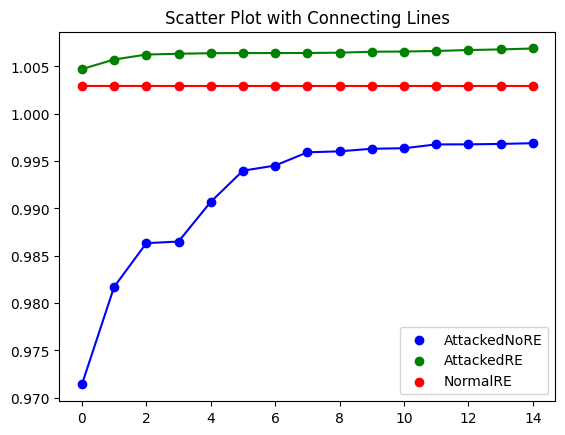

In [17]:
import matplotlib.pyplot as plt

# 将三个列表的值从小到大排序
AttackedNoRE_res_list.sort()
AttackedRE_res_list.sort()
NormalRE_res_list.sort()

# 设置颜色列表
colors = ['blue', 'green', 'red']

# 绘制散点图并连线
plt.scatter(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color=colors[0], label='AttackedNoRE')
plt.plot(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color=colors[0])

plt.scatter(range(len(AttackedRE_res_list)), AttackedRE_res_list, color=colors[1], label='AttackedRE')
plt.plot(range(len(AttackedRE_res_list)), AttackedRE_res_list, color=colors[1])

plt.scatter(range(len(NormalRE_res_list)), NormalRE_res_list, color=colors[2], label='NormalRE')
plt.plot(range(len(NormalRE_res_list)), NormalRE_res_list, color=colors[2])

# 设置图例和标题
plt.legend()
plt.title('Scatter Plot with Connecting Lines')

# 显示图形
plt.show()